In [1]:
# Compare three different algorithms: Dynamic Pricing, Adaptive Pricing, and FCFS
# Use intercepts and slopes from initialization.py as starting point for linear demand curve
# Dynamic Pricing: 
    # Retail Price Optimization at InterContinental Hotels Group. 
    # INFORMS Journal on Applied Analytics 42(1):45-57. 
    # https://doi.org/10.1287/inte.1110.0620

# Adaptive Pricing: Developed by me, adapted from:
    # Revenue Management Without Forecasting or Optimization: An Adaptive Algorithm for Determining Airline Seat Protection Levels
    # Management Science 46(6):760-775.
    # https://doi.org/10.1287/mnsc.46.6.760.11936
    
# FCFS: First-Come, First-Serve

In [2]:
import os
import sys
from sys import stdout
import argparse

import itertools
from operator import itemgetter
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from cvxopt import matrix, solvers, spmatrix
import matplotlib.pyplot as plt

# Import linear demand curve coefficients and initialized paratemers 
from initialize import initialize
from genregparam import linparams
from RADs import stay_index

np.set_printoptions(precision=2, suppress=True)

In [3]:
parser = argparse.ArgumentParser(description="Run all 8 scenarios sequantially.")
parser.add_argument('simulations', type=int, help="Number of simulations to run")
args = parser.parse_args(['120'])
n_sims = args.simulations
print('#'*n_sims)

########################################################################################################################


In [4]:
# Use arguments for different scenario: 
# --demand intensity levels: {high, low}
# --demand slopes levels: {high, low}
# --weekly single night room rate levels: {high, low}
parser = argparse.ArgumentParser(description="Comparing hotel room pricing strategies.")
parser.add_argument('--simulations', type=int, default=100, help='Number of simulations')
parser.add_argument('--weeks', type=int, default=30, help='Number of weeks to consider for simulation')
parser.add_argument('--capacity', type=int, default=100, help='Hotel capacity (total available rooms for sale)')
parser.add_argument('intensity', type=str, choices=['high', 'low'], help='Demand intensity')
parser.add_argument('slopes', type=str, choices=['high', 'low'], help='Demand slopes')
parser.add_argument('rates', type=str, choices=['high', 'low'], help='Rates for class 1')

args = parser.parse_args(['high', 'high', 'low', '--simulations', '100'])

In [5]:
# Booking classes for each stay night for week 1
# There is no Saturday or Friday arrivals that span Sunday night if it is week 1
# Similarly, there is no Saturday arrivals that span Monday night in week 1
stay_index_wk1 = [(0, 0, 0), (0, 0, 1), (0, 0, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2)]
mon_stay_index_wk1 = [(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 0, 1), (0, 0, 2), 
                     (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 0, 1), (1, 0, 2)]
stay_index_wk1 = [stay_index_wk1, mon_stay_index_wk1] + stay_index[2:]

In [6]:
# Parameters for simulation study, considering 8 different scenarios
n_class = 2
los = 3
weeks = args.weeks
capacity = args.capacity

if (args.intensity=='high') & (args.slopes=='high') & (args.rates=='high'):
    intensity = 1.5
    slopes_init = np.array([-0.1, -0.15])
    rates_init = rates_init = np.array([[160, 160, 160, 160, 160, 128, 128],
                       [90, 90, 90, 90, 90, 72, 72]])
    csvfilename = 'result_HHH.csv'
elif (args.intensity=='high') & (args.slopes=='high') & (args.rates=='low'):
    intensity = 1.5
    slopes_init = np.array([-0.1, -0.15])
    rates_init = np.array([[135, 135, 135, 135, 135, 108, 108],
                       [115, 115, 115, 115, 115, 92, 92]])
    csvfilename = 'result_HHL.csv'
elif (args.intensity=='high') & (args.slopes=='low') & (args.rates=='high'):
    intensity = 1.5
    slopes_init = np.array([-0.05, -0.10])
    rates_init = rates_init = np.array([[160, 160, 160, 160, 160, 128, 128],
                       [90, 90, 90, 90, 90, 72, 72]])
    csvfilename = 'result_HLH.csv'
elif (args.intensity=='high') & (args.slopes=='low') & (args.rates=='low'):
    intensity = 1.5
    slopes_init = np.array([-0.05, -0.10])
    rates_init = np.array([[135, 135, 135, 135, 135, 108, 108],
                       [115, 115, 115, 115, 115, 92, 92]])
    csvfilename = 'result_HLL.csv'
elif (args.intensity=='low') & (args.slopes=='high') & (args.rates=='high'):
    intensity = 0.9
    slopes_init = np.array([-0.1, -0.15])
    rates_init = rates_init = np.array([[160, 160, 160, 160, 160, 128, 128],
                       [90, 90, 90, 90, 90, 72, 72]])
    csvfilename = 'result_LHH.csv'
elif (args.intensity=='low') & (args.slopes=='high') & (args.rates=='low'):
    intensity = 0.9
    slopes_init = np.array([-0.1, -0.15])
    rates_init = np.array([[135, 135, 135, 135, 135, 108, 108],
                       [115, 115, 115, 115, 115, 92, 92]])
    csvfilename = 'result_LHL.csv'
elif (args.intensity=='low') & (args.slopes=='low') & (args.rates=='high'):
    intensity = 0.9
    slopes_init = np.array([-0.05, -0.10])
    rates_init = rates_init = np.array([[160, 160, 160, 160, 160, 128, 128],
                       [90, 90, 90, 90, 90, 72, 72]])
    csvfilename = 'result_LLH.csv'
else:
    intensity = 0.9
    slopes_init = np.array([-0.05, -0.10])
    rates_init = np.array([[135, 135, 135, 135, 135, 108, 108],
                       [115, 115, 115, 115, 115, 92, 92]])
    csvfilename = 'result_LLL.csv'
    
# For adaptive pricing algorithm, we have two parameters for step size: param1 and param2
param1, param2 = 200, 10

# Total combinations of arrivals
combs = n_class * 7 * los

In [7]:
# Partitioned protection levels, nested protection levels, representative revenue, and
# discount ration for each virtual bucket, each stay night
buckets, thetas_prt, thetas, rates_vir, ratios = initialize(capacity, intensity, rates_init)
slopes, intercepts = linparams(capacity, intensity, slopes_init, rates_init)

In [8]:
thetas_init = [np.minimum(thetas[i], capacity)[:-1] for i in range(7)]
thetas_init

[array([ 12.,  36., 100.]),
 array([12., 36., 72., 96.]),
 array([12., 24., 72., 84.]),
 array([36., 60., 72.]),
 array([24., 60., 72.]),
 array([12., 24., 36., 60.]),
 array([12., 24., 48., 72.])]

In [9]:
# Define a function to calculate rates for multiple stay nights
def moving_sum(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:]

# Define a function to compute sum of first half and second half of an array
def sum_of_elements(arr):
    n = len(arr) // 2
    sumfirst = sum(arr[:n])
    sumsecond = sum(arr[n:])
    return sumfirst, sumsecond

In [98]:
# List all the buckets that a booking class belongs to
# These buckets could span multiple stay nights, for example, Sunday arrival and 
# 3-night stay spans Sunday, Monday, and Tuesday. Therefore, this booking class appears 
# in one of the buckets of each of Sunday stay night, Monday stay night, and Tuesday stay night.
bkClass_bkt = []
for i in range(len(buckets)):
    for j in range(len(buckets[i])):
        for item in buckets[i][j]:
            bkClass_bkt.append((item, (i, j)))
            
# Dictionary form
bkClass_bkt_dict = {}
for i in range(len(buckets)):
    for j in range(len(buckets[i])):
        for item in buckets[i][j]:
            bkClass_bkt_dict[item] = (i, j)

In [106]:
thetas_wk1[1]

array([12., 36., 72., 96.])

In [107]:
span_ls

[(0, 1), (1, 1), (2, 0)]

In [114]:
cls = (0, 0, 2)
span_ls = [el[1] for el in bkClass_bkt if el[0] == cls]
[thetas_wk1[0+1][el[1]] for el in span_ls if cls[2] > 0]

[36.0, 36.0, 12.0]

In [11]:
############################ Quadratic Programming ############################

############################ Step 1 ############################
# Flatten arrays for quadratic programming formulation
slopes_flat = slopes.reshape(n_class * 7 * los)
intercepts_flat = intercepts.reshape(n_class * 7 * los)

############################ Step 2 ############################
# Inequality equations, LHS
# We have total number of 42 decision veriables, corresponding to total number of
# rate class, arrival day of week and los combinations.
# Column indexes 0-20 are associated with decision variables for rate class 1
# Column indexes 21-41 are associated with decision variables for rate class 2
G = np.zeros(7 * los * n_class * 7).reshape(7, n_class*7*los)
# Arrivals that span Sunday stay night for rate class 1
G[0,:(7*los)] = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# Arrivals that span Monday stay night for rate class 1
G[1,:(7*los)] = [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
G[2,:(7*los)] = [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
G[3,:(7*los)] = [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
G[4,:(7*los)] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
G[5,:(7*los)] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0]
G[6,:(7*los)] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]
# Arrivals that span Sunday stay night for rate class 2
G[0,(7*los):] = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# Arrivals that span Monday stay night for rate class 2
G[1,(7*los):] = [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
G[2,(7*los):] = [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
G[3,(7*los):] = [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
G[4,(7*los):] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
G[5,(7*los):] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0]
G[6,(7*los):] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]

h1 = intercepts_flat * G

############################ Step 3 ############################
# Here, be careful. For the capacity constraints, LHS is sum of demands that span
# a specific stay night in question. But decision variables for quadratic programming
# are rates. 
# demand1 + demand2 + demand3 = intercept1 + slope1 * rate1 + intercept2 + slope2 * rate2 + 
# intercept3 + slope3 * rate3 <= capacity
# --> slope1*rate1 + slope2*rate2 + slope3*rate3 <= capacity - (intercept1+intercept2+intercept3)
h1 = np.sum(h1, axis=1)
# G for capacity constraints, Negative identity matrix for non-negativity
G = slopes_flat * G
G = np.concatenate((G, -np.identity(combs)), axis=0)
# Inequality equations, RHS
# First h for capacity rhs and second component for non-negativity rhs.
h = np.concatenate((capacity * np.ones(7) - h1, np.zeros(combs)), axis=0)

############################ Step 4 ############################
# This part is a little bit tedious, but I couldn't find an elegant way of doing it
# Purpose of this section is to make sure optimal rates for e.g., Monday arrival two-night 
# stay is equal to optimal rate for Monday arrival one-night stay and Tuesday arrival one-
# night stay. This is how the rates are calculated in hotel industry for multiple nights stay.
# It is different from airline pricing with multiple legs.
arr1 = [3*i for i in range(14)]
arr2 = [(3*i) for i in range(1, 7)] + [0] + [(3*i) % 42 for i in range(8, 14)] + [21]
arr3 = [3*(i+2) % 21 for i in range(7)] + [3*(i+2) for i in range(7, 12)] + [21] + [24]
arr4 = np.concatenate((np.arange(1, 41, 3), np.arange(2, 42, 3))).tolist()
els = np.concatenate((np.repeat(1.0, 70), np.repeat(-1, 28)))
A = spmatrix(els, np.concatenate((range(28), range(28), range(14, 28), range(28))).tolist(), 
             arr1 + arr1 + arr2 + arr2 + arr3 + arr4)
b = matrix(np.zeros(28))

############################ Step 5 ############################
# Quadratic programming
#                  minimize (1/2)x_T*Q*x + p_T*x
#                  subject to G*x <= h
#                             A*x = b
slopes_diag = np.diag(slopes_flat)
Q = 2 * matrix(-slopes_diag)
p = matrix(-intercepts_flat)

# Convert numpy arrays to cvxopt matrix forms
G = matrix(G)
h = matrix(h)

############################ Step 6 ############################
# Solve quadratic programming
sol = solvers.qp(Q, p, G, h, A, b)
print(sol['status'])

############################ Step 7 ############################
rates_DP = np.array(sol['x']).reshape(n_class, 7, los)
rates_DP = np.round(rates_DP, 0)

############################ Step 8 ############################
# Check if the rates for multiple los is satisfied, one can look at rate for e.g., Sunday arrival
# three night stay for rate class 1, $405, should equal to Sunday arrival one-night stay,
# Monday arrival one-night stay, and Tuesday arrival, one-night stay.
# And indeed 405 = 112 + 149 + 143 (exits rounding error, of course)
rates_DP

optimal


array([[[ 97., 268., 414.],
        [171., 316., 459.],
        [145., 288., 438.],
        [143., 292., 415.],
        [149., 273., 417.],
        [123., 268., 365.],
        [145., 242., 413.]],

       [[ 80., 226., 357.],
        [146., 276., 403.],
        [131., 257., 386.],
        [127., 256., 362.],
        [129., 235., 367.],
        [106., 238., 318.],
        [132., 212., 358.]]])

In [12]:
######################## Start Simulation ########################
################################################################################################
################################################################################################
################################################################################################
################################################################################################
################################################################################################

In [13]:
# Week 1 buckets are slighlt different from general buckets since there is no previous
# week booking classes that span Sunday or Monday stay nights
buckets_wk1 = buckets.copy()
for i in range(7):
    # Sunday of first week, there is no previous week Saturday or Friday arrival that span Sunday
    if i == 0:
        buckets_wk1[i] = [[rad for rad in rads if rad[1] == 0] for rads in buckets[i]]
    # Monday of first week, there is no previous week Saturday arrival that span Monday
    elif i == 1:
        buckets_wk1[i] = [[rad for rad in rads if rad[1] != 6] for rads in buckets[i]]
    else:
        buckets_wk1[i] = buckets[i]

In [69]:
######################## Week 1 ########################

######################## Step1 : Based on the rates, generate demand ########################
# Initialize rates for adaptive pricing algorithm and first-come, first-serve approach
# For the first two weeks, we use the same initial protection levels
thetas_wk1 = thetas_init
thetas_wk2 = thetas_init
# In current week, store rates for current week and next week
wk1_rates_AP = rates_init
wk2_rates_AP = rates_init
# The reason we consider two weeks' rate is that for example, for Saturday arrival, 2-night stay
# booking requests, the rate will be Saturday stay night rate + Sunday (which is second week) stay
# night rate.
rates_for_two_weeks_AP = np.concatenate((wk1_rates_AP, wk2_rates_AP)).reshape(2, n_class, 7)
# Derive rates for rate class of r, arrival day of d and length of stay of d
rates_AP = [[moving_sum(rates_for_two_weeks_AP[:, i].reshape(2*7), j)[:7] 
                     for j in range(1, los+1)] for i in range(n_class)]
# Convert to the right shape for later calculation
rates_AP = np.array(rates_AP)
rates_AP = np.swapaxes(rates_AP, 1, 2)

# Repeat the same rate calculation for a booking class for FCFS approach
wk1_rates_FCFS = rates_init
wk2_rates_FCFS = rates_init
rates_for_two_weeks_FCFS = np.concatenate((wk1_rates_FCFS, wk2_rates_FCFS)).reshape(2, n_class, 7)

rates_FCFS = [[moving_sum(rates_for_two_weeks_FCFS[:, i].reshape(2*7), j)[:7] 
                       for j in range(1, los+1)] for i in range(n_class)]

rates_FCFS = np.array(rates_FCFS)
rates_FCFS = np.swapaxes(rates_FCFS, 1, 2)

# Order of rates as dynamic pricing rates, adaptive pricing rates, and FCFS rates
ratesAll = [rates_DP, rates_AP, rates_FCFS]

# Generate nonhomogenous Poisson process true bookings (i.e., customer demand) on a weekly basis
# the mean of the Poisson process will be equal to the linear demand curve function of the room rates
# Possion demand means are truncated at zero
mus = [np.maximum(intercepts + slopes * rates, 0) for rates in ratesAll]

demands = [[poisson.rvs(mu, size=1) for mu in np.nditer(mus_each)] for mus_each in mus]
demands = [np.array(x).reshape(n_class, 7, los) for x in demands]

demands_old_AP = demands[1]
# For FCFS approach, since we need at least two demand date to calculate demand change,
# we assume the same demand for old and new for the first week.
demands_old_FCFS = demands[2]
demands_new_FCFS = demands[2]

######################## Step 2: Calculate weekly room revenue ########################
# Consider first week stay nights, our week starts on Sunday, not Monday
nightlyRev = []
wk1SellInfo = []
wk1RoomSold_AP = []
ls_capacity = np.repeat(capacity, 7*3*2).reshape(7*2, 3)
sold_AP_dict = {}
for i in range(7):
    buckets_night = buckets[i]
    # Three different algorithms, three different scenarios to consider
    # VERY IMPORTANT: Have to use copy() function, otherwise the equality will be identity 
    # equality where when ls_capacity changes, capacity_left will also change.
    capacity_left = ls_capacity[i].copy()
    # Info about the booking class type, rooms sold and revenues (single night revenue)
    soldAll = []
    roomSold_AP = []
    # Reverse the buckets for each night under the assumption that low ranked booking
    # classes arrive first
    pl_idx = 0
    for rads in reversed(buckets_night):
        sold_bucket = []
        sold_bucket_AP = 0
        for rad in reversed(rads):
            if rad[1] != i:
                continue
            # Rooms sold equals smaller of demand and capacity left
            # Dynamic pricing
            sold_DP = min(demands[0][rad], capacity_left[0])

            # Adaptive pricing, the selling amount is constrained by the protection levels for higher classes
            try:
                BL_AP = max(capacity_left[1]-list(reversed(thetas_wk1[i]))[pl_idx], 0)
            except IndexError:
                BL_AP = capacity_left[1]

            sold_AP = min(demands[1][rad], BL_AP)
            sold_bucket_AP += sold_AP

            # First-come, first-serve
            sold_FCFS = min(demands[2][rad], capacity_left[2])

            sold = [sold_DP, sold_AP, sold_FCFS]
            # If length-of-stay is more than one night, accepting that class
            # will reduce the remaining capacity on all stay nights it spans.
            # rad[2] contains LOS.
            ls_capacity[i+np.arange(rad[2]+1)] = ls_capacity[i+np.arange(rad[2]+1)] - np.array(sold)

            rev = [ratesAll[i][rad] * sold[i] for i in range(len(demands))]
            sold_bucket.append((rad, sold, rev))
            sold_AP_dict[rad] = sold[1]
            # Update remaining capacity for the next virtual class
#             demand_now = [demands[i][rad] for i in range(3)]
#             print(rad, demand_now, capacity_left, sold)
            capacity_left = np.array(capacity_left) - np.array(sold)
        # A tuple contains information about booking class, room sold and room revenue info 
        # for each of the pricing strategy 
        soldAll.append(sold_bucket)
        # Number of rooms sold under AP, each record is total number of rooms sold for a
        # virtual booking class created in the initialization process
        roomSold_AP.append(sold_bucket_AP)
        pl_idx += 1

    # Remove empty lists
    soldAll = list(filter(None, soldAll))
    soldAll = list(itertools.chain.from_iterable(soldAll))
    
    # Each record in wk1SellInfo contains sell info for one stay night of the week
    # for example, booking classes that span Sunday stay night, room sales and revenues
    wk1SellInfo.append(soldAll)
    # Number of rooms sold just for AP algorithm
    wk1RoomSold_AP.append(roomSold_AP)

    # Extract revenue information and store it in revenue array
    revenue = [soldAll[i][2] for i in range(len(soldAll))]
    nightlyRev.append(revenue)
    # Calculate weekly revenue for each algorithm
nightlyRev = [np.array(x) for x in nightlyRev]
revSum = [np.sum(x, axis=0) for x in nightlyRev]
wk1Rev = np.sum(revSum, axis=0)
print(wk1Rev)

######################## Step 3: Update protection levels ########################
# Use adaptive pricing algoritm to derive new rates for week 3
# wk1RoomSold_AP is in the order of lower booking classes to higher booking classe,
# thus we need to reverse it back to put highest ranked class in the first position

# Derive number of rooms sold with AP strategy
sold_AP_ls = [[[sold_AP_dict[rad] for rad in bucket] for bucket in buckets_wk1[i]] for i in range(7)]
sold_AP_ls = [[np.array(x) for x in sold_AP_ls[i]] for i in range(7)]
sold_AP_sum = [[np.sum(x) for x in sold_AP_ls[i]] for i in range(7)]
wk1RoomSold_AP = [np.array(x) for x in sold_AP_sum]

# Update protection levels according to the sales info
roomSold_cumsum = [np.cumsum(x) for x in wk1RoomSold_AP]

# Compute if the demand for a class exceeds its corresponding protection levels
Y = [roomSold_cumsum[i][:-1] >= thetas_wk1[i] for i in range(7)]
# Implement Equation(2) in vanRyzin-McGill 2000
Z = [np.cumproduct(Y[i]) for i in range(7)]
# Calculate H(theta, x)
H = [ratios[i][1:] - Z[i] for i in range(7)]
thetas_new = [thetas_wk1[i] - (param1/(param2+1)) * H[i] for i in range(7)]
# Truncate at zero and sort it-- nonnegativity of protection levels 
thetas_new = [np.minimum(np.maximum(thetas_new[i], 0), capacity) for i in range(7)]
thetas_new = [sorted(thetas_new[i]) for i in range(7)]
# Round to integers
thetas_new = [np.round(thetas_new[i], 0) for i in range(7)]

######################## Step 4: Derive protection level adjustments ########################
# Create a dummy booking class 1 so that we can find the partitioned protection levels
# from nested ones in an easy way. Also, for the lowest class, nested protection level
# equals capacity.
thetas_old_full = [np.concatenate(([0], thetas_wk1[i], [capacity])) for i in range(7)]
thetas_new_full = [np.concatenate(([0], thetas_new[i], [capacity])) for i in range(7)]

# Calculate partitioned protection level changes for each bucket in each night
thetas_old_full_prt = [np.diff(thetas_old_full[i]) for i in range(7)]
thetas_new_full_prt = [np.diff(thetas_new_full[i]) for i in range(7)]

# Percent change for partitioned protection levels
# When divide by zero, we assume the change is 1, or 100%.
thetas_adj = [np.divide(thetas_new_full_prt[i], thetas_old_full_prt[i], 
                        out=(np.zeros_like(thetas_new_full_prt[i])+2),
                       where=thetas_old_full_prt[i]!=0) - 1 for i in range(7)]

######################## Step 4: Derive average rate adjustments ########################
# Compute all the changes to booking classes across all stay nights of the week
bkClass_bkt_uniq = {}
rates_adj = {}
# x extracts booking class and y extracts stay night-bucket that this particular
# booking class belong to
for x, y in bkClass_bkt:
    if x in bkClass_bkt_uniq:
        bkClass_bkt_uniq[x].append((y))
        rates_adj[x].append((thetas_adj[y[0]][y[1]]))
    else:
        bkClass_bkt_uniq[x] = [(y)]
        rates_adj[x] = [(thetas_adj[y[0]][y[1]])]
        
# Derive average changes for a booking class (i.e., r, a, d combination)
rates_adj_avg = {}
for k, v in rates_adj.items():
    avg_adj = np.round(np.mean(np.array(v)), 4)
    # For practical consideration, we truncate adjustments between -50% and 100%
    avg_adj = max(min(avg_adj, 1), -0.5)
    rates_adj_avg[k] = [(avg_adj)]
    single_rate = np.round((rates_AP[k] * (1+rates_adj_avg[k][0])) / (k[2] + 1), 0)
    rates_adj_avg[k].append((single_rate))
######################## Step 5: Derive single stay night rate recommendation ########################    
# Derive single stay night revenue for each rate class for each stay night of the week
rate_new = []
for bkt in buckets:
    # Flatten the bucket elements for each day of the week
    bkt_ls = list(itertools.chain.from_iterable(bkt))
    # For each booking class in the falttened list, extract the rates generated by the algorithm
    myRate_dict = {my_key: rates_adj_avg[my_key] for my_key in bkt_ls}

    # Store it as an array
    myRate = np.array(list(myRate_dict.values()))

    # Calculate stay night rates for each rate class for each stay night
    myRate_avg = np.round(np.mean(myRate, axis=0)[1], 0)

    # Create list for new rates to use for next week
    rate_new.append(myRate_avg)
    
rate_new = np.array(rate_new)

rate_diff = (rates_init[0] - rates_init[1]) / 2
# Set rate 1 and rate 2 by adding and subtracting a fixed
# amount
rate0_new = np.minimum(rate_new + rate_diff, 2*rates_init[0])
rate1_new = np.minimum(rate_new - rate_diff, 2*rates_init[1])
# New single night rates for next week
rates_update_AP = np.concatenate((rate0_new, rate1_new)).reshape(n_class, 7)
print(rates_update_AP)
######################## Step 6: Derive updated rate by FCFS ########################  
# Compute total demand by rate class for each stay night, which is then 
# used to calculate demand change ratio for FCFS strategy
demands_old_bynight_FCFS = [sum_of_elements(demands_old_FCFS[tuple(zip(*stay_index_wk1[i]))]) 
                            for i in range(7)]
demands_new_bynight_FCFS = [sum_of_elements(demands_new_FCFS[tuple(zip(*stay_index_wk1[i]))]) 
                            for i in range(7)]

demands_old_bynight_FCFS = np.array(demands_old_bynight_FCFS)
demands_new_bynight_FCFS = np.array(demands_new_bynight_FCFS)
# If old demand is zero, then we set adjustment ratio to be 1
with np.errstate(divide='ignore'):
    demands_adj_ratio = (demands_new_bynight_FCFS - demands_old_bynight_FCFS) / demands_old_bynight_FCFS
demands_adj_ratio[np.isnan(demands_adj_ratio)] = 1

demands_adj_ratio = np.swapaxes(demands_adj_ratio, 0, 1)
# For practical consideration, rate adjustment ratios are between [-0.5, 1]
demands_adj_ratio = np.maximum(-0.5, np.minimum(demands_adj_ratio, 1))
rates_update_FCFS = wk1_rates_FCFS * (1 + demands_adj_ratio)
rates_update_FCFS = np.minimum(rates_update_FCFS, 2*rates_init)
print(rates_update_FCFS)

[88630. 60178. 80848.]
[[120. 167. 165. 160. 148. 129. 124.]
 [100. 147. 145. 140. 128. 113. 108.]]
[[135. 135. 135. 135. 135. 108. 108.]
 [115. 115. 115. 115. 115.  92.  92.]]


In [70]:
######################## Week 2 ########################
# First of all, protection levels are updated
thetas_wk1 = thetas_wk2
thetas_wk2 = thetas_new

demands_old_FCFS = demands_new_FCFS

# In current week, store rates for current week and next week
wk1_rates_AP = wk2_rates_AP
wk2_rates_AP = rates_update_AP
rates_for_two_weeks_AP = np.concatenate((wk1_rates_AP, wk2_rates_AP)).reshape(2, n_class, 7)
# Derive rates for rate class of r, arrival day of d and length of stay of d
rates_rad_AP = [[moving_sum(rates_for_two_weeks_AP[:, i].reshape(2*7), j)[:7] 
                     for j in range(1, los+1)] for i in range(n_class)]
# Convert to the right shape for later calculation
rates_rad_AP = np.array(rates_rad_AP)
rates_rad_AP = np.swapaxes(rates_rad_AP, 1, 2)

# In current week, store rates for current week and next week
wk1_rates_FCFS = wk2_rates_FCFS
wk2_rates_FCFS = rates_update_FCFS
rates_for_two_weeks_FCFS = np.concatenate((wk1_rates_FCFS, wk2_rates_FCFS)).reshape(2, n_class, 7)
# Derive rates for rate class of r, arrival day of d and length of stay of d
rates_rad_FCFS = [[moving_sum(rates_for_two_weeks_FCFS[:, i].reshape(2*7), j)[:7] 
                   for j in range(1, los+1)] for i in range(n_class)]
# Convert to the right shape for later calculation
rates_rad_FCFS = np.array(rates_rad_FCFS)
rates_rad_FCFS = np.swapaxes(rates_rad_FCFS, 1, 2)

In [72]:
rates_rad_AP, rates_rad_FCFS

(array([[[135., 270., 405.],
         [135., 270., 405.],
         [135., 270., 405.],
         [135., 270., 378.],
         [135., 243., 351.],
         [108., 216., 336.],
         [108., 228., 395.]],
 
        [[115., 230., 345.],
         [115., 230., 345.],
         [115., 230., 345.],
         [115., 230., 322.],
         [115., 207., 299.],
         [ 92., 184., 284.],
         [ 92., 192., 339.]]]),
 array([[[135., 270., 405.],
         [135., 270., 405.],
         [135., 270., 405.],
         [135., 270., 378.],
         [135., 243., 351.],
         [108., 216., 351.],
         [108., 243., 378.]],
 
        [[115., 230., 345.],
         [115., 230., 345.],
         [115., 230., 345.],
         [115., 230., 322.],
         [115., 207., 299.],
         [ 92., 184., 299.],
         [ 92., 207., 322.]]]))

In [73]:
# Consider second week stay nights, our week starts on Sunday, not Monday
# Initialize rates for adaptive pricing algorithm and first-come, first-serve approach
# Order of rates as dynamic pricing rates, adaptive pricing rates, and FCFS rates
ratesAll = [rates_DP, rates_rad_AP, rates_rad_FCFS]
# Generate nonhomogenous Poisson process true bookings (i.e., customer demand) on a weekly basis
# the mean of the Poisson process will be equal to the linear demand curve function of the room rates
mus = [np.maximum(intercepts + slopes * rates, 0) for rates in ratesAll]
demands_next = [[poisson.rvs(mu, size=1) for mu in np.nditer(mus_each)] for mus_each in mus]
demands_next = [np.array(x).reshape(n_class, 7, los) for x in demands_next]

# demands in the second week
demands_new_FCFS = demands_next[2] # some demands might be zero

In [92]:
# Week 2 sell information
nightlyRev_next = []
wk2SellInfo = []
wk2RoomSold_AP = []

ls_capacity_wk2 = np.repeat(capacity, 7*3*2).reshape(7*2, 3)
#     wk_capacity = np.repeat(capacity, 7*3).reshape(7, 3)
#     ls_capacity_wk2 = np.concatenate((ls_capacity[7:], wk_capacity))
sold_AP_wk2_dict = {}

for i in range(7):
    buckets_night = buckets[i]
    # Three different algorithms, three different scenarios to consider
    capacity_left = ls_capacity_wk2[i].copy()
    # Info about the booking class type, rooms sold and revenues (single night revenue)
    soldAll = []
    roomSold_AP = []
    # Reverse the buckets for each night under the assumption that low ranked booking
    # classes arrive first
    pl_idx = 0
    for rads in reversed(buckets_night):
        sold_bucket = []
        sold_bucket_AP = 0
        for rad in reversed(rads):
            if rad[1] != i:
                continue
            # Rooms sold equals smaller of demand and capacity left
            # Dynamic pricing
            sold_DP = min(demands_next[0][rad], capacity_left[0])

            # Adaptive pricing, the selling amount is constrained by the protection levels for higher classes
            try:
                BL_AP = max(capacity_left[1]-list(reversed(thetas_wk1[i]))[pl_idx], 0) #????????????
            except IndexError:
                BL_AP = capacity_left[1]

            sold_AP = min(demands_next[1][rad], BL_AP)

            sold_bucket_AP += sold_AP

            # First-come, first-serve
            sold_FCFS = min(demands_next[2][rad], capacity_left[2])

            sold = [sold_DP, sold_AP, sold_FCFS]

            # If length-of-stay is more than one night, accepting that class
            # will reduce the remaining capacity on all stay nights it spans.
            # rad[2] contains LOS.
            ls_capacity_wk2[i+np.arange(rad[2]+1)] = ls_capacity_wk2[i+np.arange(rad[2]+1)] - np.array(sold)

            rev = [ratesAll[i][rad] * sold[i] for i in range(len(demands_next))]
            sold_bucket.append((rad, sold, rev))
            sold_AP_wk2_dict[rad] = sold[1]
#                 demand_now = [demands_next[i][rad] for i in range(3)]
#                 print(rad, demand_now, capacity_left, sold)
            # Update remaining capacity for the next virtual class
            capacity_left = np.array(capacity_left) - np.array(sold)
#             print(demands_next[0][rad], demands_next[1][rad], demands_next[2][rad], capacity_left)

        soldAll.append(sold_bucket)
        roomSold_AP.append(sold_bucket_AP)
        pl_idx += 1

    # Remove empty lists
    soldAll = list(filter(None, soldAll))
    soldAll = list(itertools.chain.from_iterable(soldAll))

    wk2SellInfo.append(soldAll)
#         wk2RoomSold_AP.append(roomSold_AP)

    # Extract revenue information and store it in revenue array
    revenue = [soldAll[i][2] for i in range(len(soldAll))]
    nightlyRev_next.append(revenue)

    # Calculate weekly revenue for each algorithm
nightlyRev_next = [np.array(x) for x in nightlyRev_next]
revSum = [np.sum(x, axis=0) for x in nightlyRev_next]
wk2Rev = np.sum(revSum, axis=0)
wk2Rev

[100 100 100]
[62 66 68]
[70 78 68]
[74 84 73]
[76 67 65]
[75 62 64]
[75 72 60]


array([91964., 57719., 81992.])

In [96]:
sold_AP_wk2_dict

{(1, 0, 2): 11,
 (1, 0, 1): 12,
 (1, 0, 0): 24,
 (0, 0, 0): 17.0,
 (0, 0, 1): 0.0,
 (0, 0, 2): 11,
 (1, 1, 2): 0,
 (1, 1, 1): 0,
 (1, 1, 0): 0,
 (0, 1, 0): 0,
 (0, 1, 1): 0,
 (0, 1, 2): 0,
 (1, 2, 2): 0,
 (1, 2, 1): 0,
 (1, 2, 0): 0,
 (0, 2, 0): 6.0,
 (0, 2, 1): 10,
 (0, 2, 2): 6,
 (1, 3, 2): 12.0,
 (1, 3, 1): 0.0,
 (1, 3, 0): 0.0,
 (0, 3, 0): 12.0,
 (0, 3, 1): 7,
 (0, 3, 2): 8,
 (1, 4, 2): 0,
 (1, 4, 1): 0,
 (1, 4, 0): 0,
 (0, 4, 0): 7.0,
 (0, 4, 2): 8,
 (0, 4, 1): 10,
 (1, 5, 1): 2.0,
 (1, 5, 0): 0.0,
 (0, 5, 1): 0.0,
 (0, 5, 0): 0.0,
 (1, 5, 2): 15,
 (0, 5, 2): 3,
 (1, 6, 0): 0.0,
 (0, 6, 0): 0.0,
 (1, 6, 1): 16,
 (0, 6, 1): 16,
 (1, 6, 2): 13,
 (0, 6, 2): 6}

In [95]:
buckets[1]

[[(0, 6, 2)],
 [(1, 6, 2), (0, 0, 2)],
 [(0, 0, 1), (1, 0, 1), (1, 0, 2)],
 [(0, 1, 2), (0, 1, 1)],
 [(0, 1, 0), (1, 1, 0), (1, 1, 1), (1, 1, 2)]]

In [94]:
thetas_wk1[1]

array([12., 36., 72., 96.])

In [86]:
wk2SellInfo

[[((1, 0, 2), [5, 11, 8], [1785.0, 3795.0, 2760.0]),
  ((1, 0, 1), [15, 12, 12], [3390.0, 2760.0, 2760.0]),
  ((1, 0, 0), [32, 24, 28], [2560.0, 2760.0, 3220.0]),
  ((0, 0, 0), [22, 17.0, 29], [2134.0, 2295.0, 3915.0]),
  ((0, 0, 1), [8, 0.0, 7], [2144.0, 0.0, 1890.0]),
  ((0, 0, 2), [10, 11, 5], [4140.0, 4455.0, 2025.0])],
 [((1, 1, 2), [0, 0, 8], [0.0, 0.0, 2760.0]),
  ((1, 1, 1), [8, 0, 11], [2208.0, 0.0, 2530.0]),
  ((1, 1, 0), [20, 0, 17], [2920.0, 0.0, 1955.0]),
  ((0, 1, 0), [22, 0, 32], [3762.0, 0.0, 4320.0]),
  ((0, 1, 1), [5, 0, 0], [1580.0, 0.0, 0.0]),
  ((0, 1, 2), [2, 0, 0], [918.0, 0.0, 0.0])],
 [((1, 2, 2), [1, 0, 10], [386.0, 0.0, 3450.0]),
  ((1, 2, 1), [6, 0, 9], [1542.0, 0.0, 2070.0]),
  ((1, 2, 0), [18, 0, 32], [2358.0, 0.0, 3680.0]),
  ((0, 2, 0), [25, 6.0, 17], [3625.0, 810.0, 2295.0]),
  ((0, 2, 1), [15, 10, 0.0], [4320.0, 2700.0, 0.0]),
  ((0, 2, 2), [2, 6, 0.0], [876.0, 2430.0, 0.0])],
 [((1, 3, 2), [3, 12.0, 9], [1086.0, 3864.0, 2898.0]),
  ((1, 3, 1), [6, 0.0

In [78]:


weeklyRev.append(wk2Rev)

################################################################################
################################################################################
################################################################################

# Use adaptive pricing algoritm to derive new rates for week 3
sold_AP_wk2_ls = [[[sold_AP_wk2_dict[rad] for rad in bucket] for bucket in buckets[i]] for i in range(7)]
sold_AP_wk2_ls = [[np.array(x) for x in sold_AP_wk2_ls[i]] for i in range(7)]
sold_AP_wk2_sum = [[np.sum(x) for x in sold_AP_wk2_ls[i]] for i in range(7)]
wk2RoomSold_AP = [np.array(x) for x in sold_AP_wk2_sum]

# Update protection levels according to the sales info
roomSold_cumsum = [np.cumsum(x) for x in wk2RoomSold_AP]

################################################################################
################################################################################
################################################################################

# Compute if the demand for a class exceeds its corresponding protection levels
Y = [roomSold_cumsum[i][:-1] >= thetas_wk1[i] for i in range(7)]
# Implement Equation(2) in vanRyzin-McGill 2000
Z = [np.cumproduct(Y[i]) for i in range(7)]
# Calculate H(theta, x)
H = [ratios[i][1:] - Z[i] for i in range(7)]
thetas_new = [thetas_wk1[i] - (param1/(param2+1)) * H[i] for i in range(7)]
# Truncate at zero and sort it-- nonnegativity of protection levels 
thetas_new = [np.minimum(np.maximum(thetas_new[i], 0), capacity) for i in range(7)]
thetas_new = [sorted(thetas_new[i]) for i in range(7)]
# Round to integers
thetas_new = [np.round(thetas_new[i], 0) for i in range(7)]
################################################################################
################################################################################
################################################################################

# Create a dummy booking class 1 so that we can find the partitioned protection levels
# from nested ones in an easy way
thetas_old_full = [np.concatenate(([0], thetas_wk1[i], [capacity])) for i in range(7)]
thetas_new_full = [np.concatenate(([0], thetas_new[i], [capacity])) for i in range(7)]

# Calculate partitioned protection level changes for each bucket in each night
thetas_old_full_prt = [np.diff(thetas_old_full[i]) for i in range(7)]
thetas_new_full_prt = [np.diff(thetas_new_full[i]) for i in range(7)]

# Percent change for partitioned protection levels
# When divide by zero, we assume the change is 1, or 100%.
thetas_adj = [np.divide(thetas_new_full_prt[i], thetas_old_full_prt[i], 
                        out=(np.zeros_like(thetas_new_full_prt[i])+2),
                       where=thetas_old_full_prt[i]!=0) - 1 for i in range(7)]
################################################################################
################################################################################
################################################################################

bkClass_bkt_uniq = {}
rates_adj = {}
for x, y in bkClass_bkt:
    if x in bkClass_bkt_uniq:
        bkClass_bkt_uniq[x].append((y))
        rates_adj[x].append((thetas_adj[y[0]][y[1]]))
    else:
        bkClass_bkt_uniq[x] = [(y)]
        rates_adj[x] = [(thetas_adj[y[0]][y[1]])]
################################################################################
################################################################################
################################################################################

# Derive average changes for a booking class (i.e., r, a, d combination)
rates_adj_avg = {}
for k, v in rates_adj.items():
    avg_adj = np.round(np.mean(np.array(v)), 4)
    avg_adj = max(min(avg_adj, 1), -0.5)
    rates_adj_avg[k] = [(avg_adj)]
    single_rate = np.round((rates_rad_AP[k] * (1+rates_adj_avg[k][0])) / (k[2] + 1), 0)
    rates_adj_avg[k].append((single_rate))

################################################################################
################################################################################
################################################################################

# Derive single stay night revenue for each rate class for each stay night of the week
rate_new = []
for bkt in buckets:
    # Flatten the bucket elements for each day of the week
    bkt_ls = list(itertools.chain.from_iterable(bkt))
    # For each booking class in the falttened list, extract the rates generated by the algorithm
    myRate_dict = {my_key: rates_adj_avg[my_key] for my_key in bkt_ls}

    # Store it as an array
    myRate = np.array(list(myRate_dict.values()))

    # Calculate stay night rates for each rate class for each stay night
    myRate_avg = np.round(np.mean(myRate, axis=0)[1], 0)

    # Create list for new rates to use for next week
    rate_new.append(myRate_avg)

rate_new = np.array(rate_new)
rate_diff = (rates_init[0] - rates_init[1]) / 2
# Set rate 1 and rate 2 by adding and subtracting a fixed
# amount
rate0_new = np.minimum(rate_new + rate_diff, 2*rates_init[0])
rate1_new = np.minimum(rate_new - rate_diff, 2*rates_init[1])

# New single night rates for next week
rates_update_AP = np.concatenate((rate0_new, rate1_new)).reshape(n_class, 7)
print(rates_update_AP)
################################################################################
################################################################################
################################################################################

# Compute total demand by rate class for each stay night, which is then 
# used to calculate demand change ratio for FCFS strategy
demands_old_bynight_FCFS = [sum_of_elements(demands_old_FCFS[tuple(zip(*stay_index[i]))]) 
                            for i in range(7)]
demands_new_bynight_FCFS = [sum_of_elements(demands_new_FCFS[tuple(zip(*stay_index[i]))]) 
                            for i in range(7)]

demands_old_bynight_FCFS = np.array(demands_old_bynight_FCFS)
demands_new_bynight_FCFS = np.array(demands_new_bynight_FCFS)
with np.errstate(divide='ignore'):
    demands_adj_ratio = (demands_new_bynight_FCFS - demands_old_bynight_FCFS) / demands_old_bynight_FCFS
demands_adj_ratio[np.isnan(demands_adj_ratio)] = 1

demands_adj_ratio = np.swapaxes(demands_adj_ratio, 0, 1)
demands_adj_ratio = np.maximum(-0.5, np.minimum(demands_adj_ratio, 1))
rates_update_FCFS = wk1_rates_FCFS * (1 + demands_adj_ratio)

rates_update_FCFS = np.round(np.minimum(rates_update_FCFS, 2*rates_init), 0)

[[122. 166. 165. 160. 148. 130. 127.]
 [102. 146. 145. 140. 128. 114. 111.]]


In [79]:
sold_bucket_AP

6

In [68]:
######################## Week 2 ########################

weeklyRev = []
for week in range(2, 31):
    # First of all, protection levels are updated
    thetas_wk1 = thetas_wk2
    thetas_wk2 = thetas_new
    
    demands_old_FCFS = demands_new_FCFS

    # In current week, store rates for current week and next week
    wk1_rates_AP = wk2_rates_AP
    wk2_rates_AP = rates_update_AP
    rates_for_two_weeks_AP = np.concatenate((wk1_rates_AP, wk2_rates_AP)).reshape(2, n_class, 7)
    # Derive rates for rate class of r, arrival day of d and length of stay of d
    rates_rad_AP = [[moving_sum(rates_for_two_weeks_AP[:, i].reshape(2*7), j)[:7] 
                         for j in range(1, los+1)] for i in range(n_class)]
    # Convert to the right shape for later calculation
    rates_rad_AP = np.array(rates_rad_AP)
    rates_rad_AP = np.swapaxes(rates_rad_AP, 1, 2)

    # In current week, store rates for current week and next week
    wk1_rates_FCFS = wk2_rates_FCFS
    wk2_rates_FCFS = rates_update_FCFS
    rates_for_two_weeks_FCFS = np.concatenate((wk1_rates_FCFS, wk2_rates_FCFS)).reshape(2, n_class, 7)
    # Derive rates for rate class of r, arrival day of d and length of stay of d
    rates_rad_FCFS = [[moving_sum(rates_for_two_weeks_FCFS[:, i].reshape(2*7), j)[:7] 
                       for j in range(1, los+1)] for i in range(n_class)]
    # Convert to the right shape for later calculation
    rates_rad_FCFS = np.array(rates_rad_FCFS)
    rates_rad_FCFS = np.swapaxes(rates_rad_FCFS, 1, 2)

    ################################################################################
    ################################################################################
    ################################################################################

    # Consider second week stay nights, our week starts on Sunday, not Monday
    # Initialize rates for adaptive pricing algorithm and first-come, first-serve approach
    # Order of rates as dynamic pricing rates, adaptive pricing rates, and FCFS rates
    ratesAll = [rates_DP, rates_rad_AP, rates_rad_FCFS]
    # Generate nonhomogenous Poisson process true bookings (i.e., customer demand) on a weekly basis
    # the mean of the Poisson process will be equal to the linear demand curve function of the room rates
    mus = [np.maximum(intercepts + slopes * rates, 0) for rates in ratesAll]
    demands_next = [[poisson.rvs(mu, size=1) for mu in np.nditer(mus_each)] for mus_each in mus]
    demands_next = [np.array(x).reshape(n_class, 7, los) for x in demands_next]
    
    # demands in the second week
    demands_new_FCFS = demands_next[2] # some demands might be zero

    ################################################################################
    ################################################################################
    ################################################################################

    # Week 2 sell information
    nightlyRev_next = []
    wk2SellInfo = []
    wk2RoomSold_AP = []
    
    ls_capacity_wk2 = np.repeat(capacity, 7*3*2).reshape(7*2, 3)
#     wk_capacity = np.repeat(capacity, 7*3).reshape(7, 3)
#     ls_capacity_wk2 = np.concatenate((ls_capacity[7:], wk_capacity))
    sold_AP_wk2_dict = {}
    
    for i in range(7):
        buckets_night = buckets[i]
        # Three different algorithms, three different scenarios to consider
        capacity_left = ls_capacity_wk2[i].copy()
        # Info about the booking class type, rooms sold and revenues (single night revenue)
        soldAll = []
        roomSold_AP = []
        # Reverse the buckets for each night under the assumption that low ranked booking
        # classes arrive first
        pl_idx = 0
        for rads in reversed(buckets_night):
            sold_bucket = []
            sold_bucket_AP = 0
            for rad in reversed(rads):
                if rad[1] != i:
                    continue
                # Rooms sold equals smaller of demand and capacity left
                # Dynamic pricing
                sold_DP = min(demands_next[0][rad], capacity_left[0])
                
                # Adaptive pricing, the selling amount is constrained by the protection levels for higher classes
                try:
                    BL_AP = max(capacity_left[1]-list(reversed(thetas_wk1[i]))[pl_idx], 0) #????????????
                except IndexError:
                    BL_AP = capacity_left[1]
                    
                sold_AP = min(demands_next[1][rad], BL_AP)
                
                sold_bucket_AP += sold_AP
                
                # First-come, first-serve
                sold_FCFS = min(demands_next[2][rad], capacity_left[2])

                sold = [sold_DP, sold_AP, sold_FCFS]
                
                # If length-of-stay is more than one night, accepting that class
                # will reduce the remaining capacity on all stay nights it spans.
                # rad[2] contains LOS.
                ls_capacity_wk2[i+np.arange(rad[2]+1)] = ls_capacity_wk2[i+np.arange(rad[2]+1)] - np.array(sold)
                
                rev = [ratesAll[i][rad] * sold[i] for i in range(len(demands_next))]
                sold_bucket.append((rad, sold, rev))
                sold_AP_wk2_dict[rad] = sold[1]
#                 demand_now = [demands_next[i][rad] for i in range(3)]
#                 print(rad, demand_now, capacity_left, sold)
                # Update remaining capacity for the next virtual class
                capacity_left = np.array(capacity_left) - np.array(sold)
                
            soldAll.append(sold_bucket)
            roomSold_AP.append(sold_bucket_AP)
            pl_idx += 1

        # Remove empty lists
        soldAll = list(filter(None, soldAll))
        soldAll = list(itertools.chain.from_iterable(soldAll))
        
        wk2SellInfo.append(soldAll)
#         wk2RoomSold_AP.append(roomSold_AP)

        # Extract revenue information and store it in revenue array
        revenue = [soldAll[i][2] for i in range(len(soldAll))]
        nightlyRev_next.append(revenue)

        # Calculate weekly revenue for each algorithm
    nightlyRev_next = [np.array(x) for x in nightlyRev_next]
    revSum = [np.sum(x, axis=0) for x in nightlyRev_next]
    wk2Rev = np.sum(revSum, axis=0)
    
    weeklyRev.append(wk2Rev)

    ################################################################################
    ################################################################################
    ################################################################################

    # Use adaptive pricing algoritm to derive new rates for week 3
    sold_AP_wk2_ls = [[[sold_AP_wk2_dict[rad] for rad in bucket] for bucket in buckets[i]] for i in range(7)]
    sold_AP_wk2_ls = [[np.array(x) for x in sold_AP_wk2_ls[i]] for i in range(7)]
    sold_AP_wk2_sum = [[np.sum(x) for x in sold_AP_wk2_ls[i]] for i in range(7)]
    wk2RoomSold_AP = [np.array(x) for x in sold_AP_wk2_sum]

    # Update protection levels according to the sales info
    roomSold_cumsum = [np.cumsum(x) for x in wk2RoomSold_AP]

    ################################################################################
    ################################################################################
    ################################################################################

    # Compute if the demand for a class exceeds its corresponding protection levels
    Y = [roomSold_cumsum[i][:-1] >= thetas_wk1[i] for i in range(7)]
    # Implement Equation(2) in vanRyzin-McGill 2000
    Z = [np.cumproduct(Y[i]) for i in range(7)]
    # Calculate H(theta, x)
    H = [ratios[i][1:] - Z[i] for i in range(7)]
    thetas_new = [thetas_wk1[i] - (param1/(param2+week)) * H[i] for i in range(7)]
    # Truncate at zero and sort it-- nonnegativity of protection levels 
    thetas_new = [np.minimum(np.maximum(thetas_new[i], 0), capacity) for i in range(7)]
    thetas_new = [sorted(thetas_new[i]) for i in range(7)]
    # Round to integers
    thetas_new = [np.round(thetas_new[i], 0) for i in range(7)]
    ################################################################################
    ################################################################################
    ################################################################################

    # Create a dummy booking class 1 so that we can find the partitioned protection levels
    # from nested ones in an easy way
    thetas_old_full = [np.concatenate(([0], thetas_wk1[i], [capacity])) for i in range(7)]
    thetas_new_full = [np.concatenate(([0], thetas_new[i], [capacity])) for i in range(7)]

    # Calculate partitioned protection level changes for each bucket in each night
    thetas_old_full_prt = [np.diff(thetas_old_full[i]) for i in range(7)]
    thetas_new_full_prt = [np.diff(thetas_new_full[i]) for i in range(7)]

    # Percent change for partitioned protection levels
    # When divide by zero, we assume the change is 1, or 100%.
    thetas_adj = [np.divide(thetas_new_full_prt[i], thetas_old_full_prt[i], 
                            out=(np.zeros_like(thetas_new_full_prt[i])+2),
                           where=thetas_old_full_prt[i]!=0) - 1 for i in range(7)]
    ################################################################################
    ################################################################################
    ################################################################################

    bkClass_bkt_uniq = {}
    rates_adj = {}
    for x, y in bkClass_bkt:
        if x in bkClass_bkt_uniq:
            bkClass_bkt_uniq[x].append((y))
            rates_adj[x].append((thetas_adj[y[0]][y[1]]))
        else:
            bkClass_bkt_uniq[x] = [(y)]
            rates_adj[x] = [(thetas_adj[y[0]][y[1]])]
    ################################################################################
    ################################################################################
    ################################################################################

    # Derive average changes for a booking class (i.e., r, a, d combination)
    rates_adj_avg = {}
    for k, v in rates_adj.items():
        avg_adj = np.round(np.mean(np.array(v)), 4)
        avg_adj = max(min(avg_adj, 1), -0.5)
        rates_adj_avg[k] = [(avg_adj)]
        single_rate = np.round((rates_rad_AP[k] * (1+rates_adj_avg[k][0])) / (k[2] + 1), 0)
        rates_adj_avg[k].append((single_rate))

    ################################################################################
    ################################################################################
    ################################################################################

    # Derive single stay night revenue for each rate class for each stay night of the week
    rate_new = []
    for bkt in buckets:
        # Flatten the bucket elements for each day of the week
        bkt_ls = list(itertools.chain.from_iterable(bkt))
        # For each booking class in the falttened list, extract the rates generated by the algorithm
        myRate_dict = {my_key: rates_adj_avg[my_key] for my_key in bkt_ls}

        # Store it as an array
        myRate = np.array(list(myRate_dict.values()))

        # Calculate stay night rates for each rate class for each stay night
        myRate_avg = np.round(np.mean(myRate, axis=0)[1], 0)

        # Create list for new rates to use for next week
        rate_new.append(myRate_avg)

    rate_new = np.array(rate_new)
    rate_diff = (rates_init[0] - rates_init[1]) / 2
    # Set rate 1 and rate 2 by adding and subtracting a fixed
    # amount
    rate0_new = np.minimum(rate_new + rate_diff, 2*rates_init[0])
    rate1_new = np.minimum(rate_new - rate_diff, 2*rates_init[1])

    # New single night rates for next week
    rates_update_AP = np.concatenate((rate0_new, rate1_new)).reshape(n_class, 7)
    print(rates_update_AP)
    ################################################################################
    ################################################################################
    ################################################################################

    # Compute total demand by rate class for each stay night, which is then 
    # used to calculate demand change ratio for FCFS strategy
    demands_old_bynight_FCFS = [sum_of_elements(demands_old_FCFS[tuple(zip(*stay_index[i]))]) 
                                for i in range(7)]
    demands_new_bynight_FCFS = [sum_of_elements(demands_new_FCFS[tuple(zip(*stay_index[i]))]) 
                                for i in range(7)]
    
    demands_old_bynight_FCFS = np.array(demands_old_bynight_FCFS)
    demands_new_bynight_FCFS = np.array(demands_new_bynight_FCFS)
    with np.errstate(divide='ignore'):
        demands_adj_ratio = (demands_new_bynight_FCFS - demands_old_bynight_FCFS) / demands_old_bynight_FCFS
    demands_adj_ratio[np.isnan(demands_adj_ratio)] = 1

    demands_adj_ratio = np.swapaxes(demands_adj_ratio, 0, 1)
    demands_adj_ratio = np.maximum(-0.5, np.minimum(demands_adj_ratio, 1))
    rates_update_FCFS = wk1_rates_FCFS * (1 + demands_adj_ratio)
    
    rates_update_FCFS = np.round(np.minimum(rates_update_FCFS, 2*rates_init), 0)

[[[243. 455. 696.]
  [212. 453. 719.]
  [241. 507. 768.]
  [266. 527. 743.]
  [261. 477. 693.]
  [216. 432. 688.]
  [216. 472. 701.]]

 [[223. 415. 636.]
  [192. 413. 643.]
  [221. 451. 681.]
  [230. 460. 644.]
  [230. 414. 598.]
  [184. 368. 598.]
  [184. 414. 623.]]] [[[14.13  0.    0.  ]
  [20.16  0.    0.  ]
  [ 8.44  0.    0.  ]
  [13.06  0.    0.  ]
  [15.73  0.    0.  ]
  [18.2   0.    0.  ]
  [ 8.76  0.    0.  ]]

 [[ 8.09  0.    0.  ]
  [17.8   0.    0.  ]
  [ 9.64  0.    0.  ]
  [ 3.3   0.    0.  ]
  [ 2.3   0.    0.  ]
  [ 7.72  0.    0.  ]
  [ 7.04  0.    0.  ]]]
[[270. 270. 270. 256. 229. 216. 216.]
 [230. 230. 230. 230. 209. 184. 184.]]
[[[256. 485. 687.]
  [229. 431. 629.]
  [202. 400. 584.]
  [198. 382. 587.]
  [184. 389. 601.]
  [205. 417. 687.]
  [212. 482. 752.]]

 [[230. 439. 621.]
  [209. 391. 569.]
  [182. 360. 524.]
  [178. 342. 526.]
  [164. 348. 532.]
  [184. 368. 598.]
  [184. 414. 644.]]] [[[12.96  0.    0.  ]
  [18.97  0.    0.  ]
  [14.68  0.    0.  ]
  [19

 [230. 230. 230. 230. 219. 184. 184.]]
[[[262. 532. 802.]
  [270. 540. 810.]
  [270. 540. 808.]
  [270. 538. 754.]
  [268. 484. 697.]
  [216. 429. 699.]
  [213. 483. 753.]]

 [[230. 460. 690.]
  [230. 460. 690.]
  [230. 460. 690.]
  [230. 460. 644.]
  [230. 414. 598.]
  [184. 368. 598.]
  [184. 414. 644.]]] [[[12.42  0.    0.  ]
  [16.1   0.    0.  ]
  [ 3.8   0.    0.  ]
  [12.7   0.    0.  ]
  [15.24  0.    0.  ]
  [18.2   0.    0.  ]
  [ 9.18  0.    0.  ]]

 [[ 6.9   0.    0.  ]
  [14.    0.    0.  ]
  [ 8.2   0.    0.  ]
  [ 3.3   0.    0.  ]
  [ 2.3   0.    0.  ]
  [ 7.72  0.    0.  ]
  [ 7.04  0.    0.  ]]]
[[270. 270. 270. 270. 270. 216. 216.]
 [230. 230. 230. 230. 230. 184. 184.]]
[[[270. 540. 810.]
  [270. 540. 800.]
  [270. 530. 769.]
  [260. 499. 715.]
  [239. 455. 671.]
  [216. 432. 702.]
  [216. 486. 756.]]

 [[230. 460. 690.]
  [230. 460. 690.]
  [230. 460. 679.]
  [230. 449. 633.]
  [219. 403. 587.]
  [184. 368. 598.]
  [184. 414. 644.]]] [[[11.7   0.    0.  ]
  [16.1   

In [60]:
weeklyRev

[array([89959., 58442., 81320.]),
 array([89388., 62383., 80352.]),
 array([92232., 56756., 76297.]),
 array([89561., 51027., 67943.]),
 array([88537., 55356., 89941.]),
 array([91633., 58444., 63493.]),
 array([88086., 56448., 66433.]),
 array([92228., 55256., 73298.]),
 array([92886., 51989., 66678.]),
 array([88686., 51778., 65015.]),
 array([95059., 56507., 66669.]),
 array([88714., 54154., 63077.]),
 array([92516., 55775., 57940.]),
 array([88046., 45883., 64600.]),
 array([95930., 57170., 42178.]),
 array([93346., 54268., 65469.]),
 array([93639., 49760., 73085.]),
 array([89147., 46521., 44971.]),
 array([94966., 55913., 64514.]),
 array([95456., 51473., 60534.]),
 array([89243., 49834., 62842.]),
 array([95005., 40977., 61892.]),
 array([87774., 51609., 64305.]),
 array([95561., 40446., 50385.]),
 array([91095., 49293., 66670.]),
 array([90600., 36235., 64747.]),
 array([92217., 45543., 54422.]),
 array([91113., 31698., 63375.]),
 array([89529., 42887., 61077.])]

In [61]:
weeklyRev = np.array(weeklyRev)

<function matplotlib.pyplot.show(*args, **kw)>

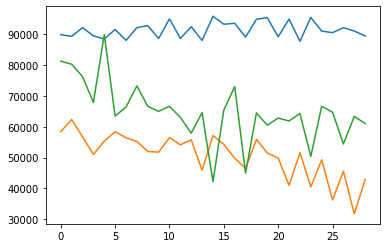

In [62]:
plt.plot(weeklyRev)
plt.show

In [13]:
sim_weeklyRev = []
num_simulations = args.simulations

for _ in range(num_simulations):
    ######################## Week 1 ########################
    weeklyRev = []
    ######################## Step1 : Based on the rates, generate demand ########################
    # Initialize rates for adaptive pricing algorithm and first-come, first-serve approach
    # In current week, store rates for current week and next week
    thetas_wk1 = thetas_init
    thetas_wk2 = thetas_init

    wk1_rates_AP = rates_init
    wk2_rates_AP = rates_init
    rates_for_two_weeks_AP = np.concatenate((wk1_rates_AP, wk2_rates_AP)).reshape(2, n_class, 7)
    # Derive rates for rate class of r, arrival day of d and length of stay of d
    rates_AP = [[moving_sum(rates_for_two_weeks_AP[:, i].reshape(2*7), j)[:7] 
                         for j in range(1, los+1)] for i in range(n_class)]
    # Convert to the right shape for later calculation
    rates_AP = np.array(rates_AP)
    rates_AP = np.swapaxes(rates_AP, 1, 2)

    # In current week, store rates for current week and next week
    wk1_rates_FCFS = rates_init
    wk2_rates_FCFS = rates_init
    rates_for_two_weeks_FCFS = np.concatenate((wk1_rates_FCFS, wk2_rates_FCFS)).reshape(2, n_class, 7)
    # Derive rates for rate class of r, arrival day of d and length of stay of d
    rates_FCFS = [[moving_sum(rates_for_two_weeks_FCFS[:, i].reshape(2*7), j)[:7] 
                           for j in range(1, los+1)] for i in range(n_class)]
    # Convert to the right shape for later calculation
    rates_FCFS = np.array(rates_FCFS)
    rates_FCFS = np.swapaxes(rates_FCFS, 1, 2)

    # Order of rates as dynamic pricing rates, adaptive pricing rates, and FCFS rates
    ratesAll = [rates_DP, rates_AP, rates_FCFS]

    # Generate nonhomogenous Poisson process true bookings (i.e., customer demand) on a weekly basis
    # the mean of the Poisson process will be equal to the linear demand curve function of the room rates
    mus = [np.maximum(intercepts + slopes * rates, 0) for rates in ratesAll]

    demands = [[poisson.rvs(mu, size=1) for mu in np.nditer(mus_each)] for mus_each in mus]
    demands = [np.array(x).reshape(n_class, 7, los) for x in demands]

    demands_old_AP = demands[1]

    demands_old_FCFS = demands[2]
    demands_new_FCFS = demands[2]

    ######################## Step 2: Calculate weekly room revenue ########################
    # Consider first week stay nights, our week starts on Sunday, not Monday
    nightlyRev = []
    wk1SellInfo = []
    wk1RoomSold_AP = []
    for i in range(7):
        # Sunday of first week, there is no previous week Saturday or Friday arrival that span Sunday
        if i == 0:
            buckets_night = [[rad for rad in rads if rad[1] == 0] for rads in buckets[i]]
        # Monday of first week, there is no previous week Saturday arrival that span Monday
        elif i == 1:
            buckets_night = [[rad for rad in rads if rad[1] != 6] for rads in buckets[i]]
        else:
            buckets_night = buckets[i]
        # Three different algorithms, three different scenarios to consider
        capacity_left = [capacity] * 3
        # Info about the booking class type, rooms sold and revenues (single night revenue)
        soldAll = []
        roomSold_AP = []
        # Reverse the buckets for each night under the assumption that low ranked booking
        # classes arrive first
        pl_idx = 0
        for rads in reversed(buckets_night):
            sold_bucket = []
            sold_bucket_AP = 0
            for rad in rads:
                # For stay night revenue calculation, we only use one-night stay revenue, not
                # multiple stay night total revenue
                rad_single = (rad[0], i, 0)
                # Rooms sold equals smaller of demand and capacity left
                # Dynamic pricing
                sold_DP = min(demands[0][rad], capacity_left[0])
                # Adaptive pricing, the selling amount is constrained by the protection levels for higher classes
                try:
                    BL_AP = max(capacity_left[1]-list(reversed(thetas_wk1[i]))[pl_idx], 0)
                except IndexError:
                    BL_AP = capacity_left[1]

                sold_AP = min(demands[1][rad], BL_AP)
                sold_bucket_AP += sold_AP
                # First-come, first-serve
                sold_FCFS = min(demands[2][rad], capacity_left[2])

                sold = [sold_DP, sold_AP, sold_FCFS]

                rev = [ratesAll[i][rad_single] * sold[i] for i in range(len(demands))]
                sold_bucket.append((rad, sold, rev))
                # Update remaining capacity for the next virtual class
                capacity_left = [capacity_left[i]-sold[i] for i in range(len(sold))]
            soldAll.append(sold_bucket)
            roomSold_AP.append(sold_bucket_AP)
            pl_idx += 1

        # Remove empty lists
        soldAll = list(filter(None, soldAll))
        soldAll = list(itertools.chain.from_iterable(soldAll))
        wk1SellInfo.append(soldAll)
        wk1RoomSold_AP.append(roomSold_AP)

        # Extract revenue information and store it in revenue array
        revenue = [soldAll[i][2] for i in range(len(soldAll))]
        nightlyRev.append(revenue)

        # Calculate weekly revenue for each algorithm
    nightlyRev = [np.array(x) for x in nightlyRev]
    revSum = [np.sum(x, axis=0) for x in nightlyRev]
    wk1Rev = np.sum(revSum, axis=0)
    weeklyRev.append(wk1Rev)

    ######################## Step 3: Update protection levels ########################
    # Use adaptive pricing algoritm to derive new rates for week 3
    wk1RoomSold_AP = [list(reversed(wk1RoomSold_AP[i])) for i in range(len(wk1RoomSold_AP))]
    wk1RoomSold_AP = [np.array(x) for x in wk1RoomSold_AP]

    # Update protection levels according to the sales info
    roomSold_cumsum = [np.cumsum(x) for x in wk1RoomSold_AP]

    # Compute if the demand for a class exceeds its corresponding protection levels
    Y = [roomSold_cumsum[i][:-1] >= thetas_wk1[i] for i in range(7)]
    # Implement Equation(2) in vanRyzin-McGill 2000
    Z = [np.cumproduct(Y[i]) for i in range(7)]
    # Calculate H(theta, x)
    H = [ratios[i][1:] - Z[i] for i in range(7)]
    thetas_new = [thetas_wk1[i] - (param1/(param2+1)) * H[i] for i in range(7)]
    # Truncate at zero and sort it-- nonnegativity of protection levels 
    thetas_new = [np.minimum(np.maximum(thetas_new[i], 0), capacity) for i in range(7)]
    thetas_new = [sorted(thetas_new[i]) for i in range(7)]
    # Round to integers
    thetas_new = [np.round(thetas_new[i], 0) for i in range(7)]

    ######################## Step 4: Derive protection level adjustments ########################
    # Create a dummy booking class 1 so that we can find the partitioned protection levels
    # from nested ones in an easy way
    thetas_old_full = [np.concatenate(([0], thetas_wk1[i], [capacity])) for i in range(7)]
    thetas_new_full = [np.concatenate(([0], thetas_new[i], [capacity])) for i in range(7)]

    # Calculate partitioned protection level changes for each bucket in each night
    thetas_old_full_prt = [np.diff(thetas_old_full[i]) for i in range(7)]
    thetas_new_full_prt = [np.diff(thetas_new_full[i]) for i in range(7)]

    # Percent change for partitioned protection levels
    # When divide by zero, we assume the change is 1, or 100%.
    thetas_adj = [np.divide(thetas_new_full_prt[i], thetas_old_full_prt[i], 
                            out=(np.zeros_like(thetas_new_full_prt[i])+2),
                           where=thetas_old_full_prt[i]!=0) - 1 for i in range(7)]

    ######################## Step 4: Derive average rate adjustments ########################
    # Compute all the changes to booking classes across all stay nights of the week
    bkClass_bkt_uniq = {}
    rates_adj = {}
    for x, y in bkClass_bkt:
        if x in bkClass_bkt_uniq:
            bkClass_bkt_uniq[x].append((y))
            rates_adj[x].append((thetas_adj[y[0]][y[1]]))
        else:
            bkClass_bkt_uniq[x] = [(y)]
            rates_adj[x] = [(thetas_adj[y[0]][y[1]])]

    # Derive average changes for a booking class (i.e., r, a, d combination)
    rates_adj_avg = {}
    for k, v in rates_adj.items():
        avg_adj = np.round(np.mean(np.array(v)), 4)
        avg_adj = max(min(avg_adj, 1), -1)
        rates_adj_avg[k] = [(avg_adj)]
        single_rate = np.round((rates_AP[k] * (1+rates_adj_avg[k][0])) / (k[2] + 1), 0)
        rates_adj_avg[k].append((single_rate))
    ######################## Step 5: Derive single stay night rate recommendation ########################    
    # Derive single stay night revenue for each rate class for each stay night of the week
    rate0_new = []
    rate1_new = []
    for bkt in buckets:
        # Flatten the bucket elements for each day of the week
        bkt_ls = list(itertools.chain.from_iterable(bkt))
        # For each booking class in the falttened list, extract the rates generated by the algorithm
        myRate0_dict = {my_key: rates_adj_avg[my_key] for my_key in bkt_ls if my_key[0] == 0}
        myRate1_dict = {my_key: rates_adj_avg[my_key] for my_key in bkt_ls if my_key[0] == 1}
        # Store it as an array
        myRate0 = np.array(list(myRate0_dict.values()))
        myRate1 = np.array(list(myRate1_dict.values()))
        # Calculate stay night rates for each rate class for each stay night
        myRate0_avg = np.round(np.mean(myRate0, axis=0)[1], 0)
        myRate1_avg = np.round(np.mean(myRate1, axis=0)[1], 0)
        # Create list for new rates to use for next week
        rate0_new.append(myRate0_avg)
        rate1_new.append(myRate1_avg)

    # New single night rates for next week
    rates_update_AP = np.concatenate((rate0_new, rate1_new)).reshape(n_class, 7)

    ######################## Step 6: Derive updated rate by FCFS ########################  
    # Compute total demand by rate class for each stay night, which is then 
    # used to calculate demand change ratio for FCFS strategy
    demands_old_bynight_FCFS = [sum_of_elements(demands_old_FCFS[tuple(zip(*stay_index_wk1[i]))]) 
                                for i in range(7)]
    demands_new_bynight_FCFS = [sum_of_elements(demands_new_FCFS[tuple(zip(*stay_index_wk1[i]))]) 
                                for i in range(7)]

    demands_old_bynight_FCFS = np.array(demands_old_bynight_FCFS)
    demands_new_bynight_FCFS = np.array(demands_new_bynight_FCFS)
    with np.errstate(divide='ignore'):
        demands_adj_ratio = (demands_new_bynight_FCFS - demands_old_bynight_FCFS) / demands_old_bynight_FCFS
    demands_adj_ratio[np.isnan(demands_adj_ratio)] = 1

    demands_adj_ratio = np.swapaxes(demands_adj_ratio, 0, 1)
    demands_adj_ratio = np.maximum(-1, np.minimum(demands_adj_ratio, 1))
    rates_update_FCFS = wk1_rates_FCFS * (1 + demands_adj_ratio)



    ######################## Week 2 ########################

    ls_rad_sun = [(0, 5, 2), (0, 6, 1), (0, 6, 2), (1, 5, 2), (1, 6, 1), (1, 6, 2)]
    for week in range(2, weeks+1):
        # First of all, protection levels are updated
        thetas_wk1 = thetas_wk2
        thetas_wk2 = thetas_new

        demands_old = demands
        # In current week, store rates for current week and next week
        wk1_rates_AP = wk2_rates_AP
        wk2_rates_AP = rates_update_AP
        rates_for_two_weeks_AP = np.concatenate((wk1_rates_AP, wk2_rates_AP)).reshape(2, n_class, 7)
        # Derive rates for rate class of r, arrival day of d and length of stay of d
        rates_rad_AP = [[moving_sum(rates_for_two_weeks_AP[:, i].reshape(2*7), j)[:7] 
                             for j in range(1, los+1)] for i in range(n_class)]
        # Convert to the right shape for later calculation
        rates_rad_AP = np.array(rates_rad_AP)
        rates_rad_AP = np.swapaxes(rates_rad_AP, 1, 2)

        # In current week, store rates for current week and next week
        wk1_rates_FCFS = wk2_rates_FCFS
        wk2_rates_FCFS = rates_update_FCFS
        rates_for_two_weeks_FCFS = np.concatenate((wk1_rates_FCFS, wk2_rates_FCFS)).reshape(2, n_class, 7)
        # Derive rates for rate class of r, arrival day of d and length of stay of d
        rates_rad_FCFS = [[moving_sum(rates_for_two_weeks_FCFS[:, i].reshape(2*7), j)[:7] 
                           for j in range(1, los+1)] for i in range(n_class)]
        # Convert to the right shape for later calculation
        rates_rad_FCFS = np.array(rates_rad_FCFS)
        rates_rad_FCFS = np.swapaxes(rates_rad_FCFS, 1, 2)

        ################################################################################
        ################################################################################
        ################################################################################

        # Consider second week stay nights, our week starts on Sunday, not Monday
        # Initialize rates for adaptive pricing algorithm and first-come, first-serve approach
        rates_AP = rates_rad_AP
        rates_FCFS = rates_rad_FCFS
        # Order of rates as dynamic pricing rates, adaptive pricing rates, and FCFS rates
        ratesAll = [rates_DP, rates_AP, rates_FCFS]
        # Generate nonhomogenous Poisson process true bookings (i.e., customer demand) on a weekly basis
        # the mean of the Poisson process will be equal to the linear demand curve function of the room rates
        mus = [np.maximum(intercepts + slopes * rates, 0) for rates in ratesAll]
        demands_next = [[poisson.rvs(mu, size=1) for mu in np.nditer(mus_each)] for mus_each in mus]
        demands_next = [np.array(x).reshape(n_class, 7, los) for x in demands_next]

        demands_new_AP = demands_next[1]
        demands_new_FCFS = demands_next[2] # some demands might be zero

        ################################################################################
        ################################################################################
        ################################################################################

        # Week 2 sell information
        nightlyRev_next = []
        wk2SellInfo = []
        wk2RoomSold_AP = []
        for i in range(7):
            buckets_night = buckets[i]
            # Three different algorithms, three different scenarios to consider
            capacity_left = [capacity] * 3
            # Info about the booking class type, rooms sold and revenues (single night revenue)
            soldAll = []
            roomSold_AP = []
            # Reverse the buckets for each night under the assumption that low ranked booking
            # classes arrive first
            pl_idx = 0
            for rads in reversed(buckets_night):
                sold_bucket = []
                sold_bucket_AP = 0
                for rad in rads:
                    # For stay night revenue calculation, we only use one-night stay revenue, not
                    # multiple stay night total revenue
                    rad_single = (rad[0], i, 0)
                    # Rooms sold equals smaller of demand and capacity left
                    # Dynamic pricing

                    sold_DP = min(demands_next[0][rad], capacity_left[0])
                    # Adaptive pricing, the selling amount is constrained by the protection levels for higher classes
                    try:
                        BL_AP = max(capacity_left[1]-list(reversed(thetas_wk1[i]))[pl_idx], 0)
                    except IndexError:
                        BL_AP = capacity_left[1]

                    sold_AP = min(demands_next[1][rad], BL_AP)
                    sold_bucket_AP += sold_AP
                    # First-come, first-serve
                    sold_FCFS = min(demands_next[2][rad], capacity_left[2])

                    sold = [sold_DP, sold_AP, sold_FCFS]

                    rev = [ratesAll[i][rad_single] * sold[i] for i in range(len(demands_next))]
                    sold_bucket.append((rad, sold, rev))
                    # Update remaining capacity for the next virtual class
                    capacity_left = [capacity_left[i]-sold[i] for i in range(len(sold))]
                soldAll.append(sold_bucket)
                roomSold_AP.append(sold_bucket_AP)
                pl_idx += 1

            # Remove empty lists
            soldAll = list(filter(None, soldAll))
            soldAll = list(itertools.chain.from_iterable(soldAll))
            wk2SellInfo.append(soldAll)
            wk2RoomSold_AP.append(roomSold_AP)

            # Extract revenue information and store it in revenue array
            revenue = [soldAll[i][2] for i in range(len(soldAll))]
            nightlyRev_next.append(revenue)

            # Calculate weekly revenue for each algorithm
        nightlyRev_next = [np.array(x) for x in nightlyRev_next]
        revSum = [np.sum(x, axis=0) for x in nightlyRev_next]
        wk2Rev = np.sum(revSum, axis=0)

        weeklyRev.append(wk2Rev)

        ################################################################################
        ################################################################################
        ################################################################################

        # Use adaptive pricing algoritm to derive new rates for week 3
        wk2RoomSold_AP = [list(reversed(wk2RoomSold_AP[i])) for i in range(len(wk2RoomSold_AP))]
        wk2RoomSold_AP = [np.array(x) for x in wk2RoomSold_AP]

        # Update protection levels according to the sales info
        roomSold_cumsum = [np.cumsum(x) for x in wk2RoomSold_AP]

        ################################################################################
        ################################################################################
        ################################################################################

        # Compute if the demand for a class exceeds its corresponding protection levels
        Y = [roomSold_cumsum[i][:-1] >= thetas_wk1[i] for i in range(7)]
        # Implement Equation(2) in vanRyzin-McGill 2000
        Z = [np.cumproduct(Y[i]) for i in range(7)]
        # Calculate H(theta, x)
        H = [ratios[i][1:] - Z[i] for i in range(7)]
        thetas_new = [thetas_wk1[i] - (param1/(param2+week)) * H[i] for i in range(7)]
        # Truncate at zero and sort it-- nonnegativity of protection levels 
        thetas_new = [np.minimum(np.maximum(thetas_new[i], 0), capacity) for i in range(7)]
        thetas_new = [sorted(thetas_new[i]) for i in range(7)]
        # Round to integers
        thetas_new = [np.round(thetas_new[i], 0) for i in range(7)]

        ################################################################################
        ################################################################################
        ################################################################################

        # Create a dummy booking class 1 so that we can find the partitioned protection levels
        # from nested ones in an easy way
        thetas_old_full = [np.concatenate(([0], thetas_wk1[i], [capacity])) for i in range(7)]
        thetas_new_full = [np.concatenate(([0], thetas_new[i], [capacity])) for i in range(7)]

        # Calculate partitioned protection level changes for each bucket in each night
        thetas_old_full_prt = [np.diff(thetas_old_full[i]) for i in range(7)]
        thetas_new_full_prt = [np.diff(thetas_new_full[i]) for i in range(7)]

        # Percent change for partitioned protection levels
        # When divide by zero, we assume the change is 1, or 100%.
        thetas_adj = [np.divide(thetas_new_full_prt[i], thetas_old_full_prt[i], 
                                out=(np.zeros_like(thetas_new_full_prt[i])+2),
                               where=thetas_old_full_prt[i]!=0) - 1 for i in range(7)]

        ################################################################################
        ################################################################################
        ################################################################################

        bkClass_bkt_uniq = {}
        rates_adj = {}
        for x, y in bkClass_bkt:
            if x in bkClass_bkt_uniq:
                bkClass_bkt_uniq[x].append((y))
                rates_adj[x].append((thetas_adj[y[0]][y[1]]))
            else:
                bkClass_bkt_uniq[x] = [(y)]
                rates_adj[x] = [(thetas_adj[y[0]][y[1]])]

        ################################################################################
        ################################################################################
        ################################################################################

        # Derive average changes for a booking class (i.e., r, a, d combination)
        rates_adj_avg = {}
        for k, v in rates_adj.items():
            avg_adj = np.round(np.mean(np.array(v)), 4)
            avg_adj = max(min(avg_adj, 1), -1)
            rates_adj_avg[k] = [(avg_adj)]
            single_rate = np.round((rates_rad_AP[k] * (1+rates_adj_avg[k][0])) / (k[2] + 1), 0)
            rates_adj_avg[k].append((single_rate))

        ################################################################################
        ################################################################################
        ################################################################################

        # Derive single stay night revenue for each rate class for each stay night of the week
        rate0_new = []
        rate1_new = []
        for bkt in buckets:
            # Flatten the bucket elements for each day of the week
            bkt_ls = list(itertools.chain.from_iterable(bkt))
            # For each booking class in the falttened list, extract the rates generated by the algorithm
            myRate0_dict = {my_key: rates_adj_avg[my_key] for my_key in bkt_ls if my_key[0] == 0}
            myRate1_dict = {my_key: rates_adj_avg[my_key] for my_key in bkt_ls if my_key[0] == 1}
            # Store it as an array
            myRate0 = np.array(list(myRate0_dict.values()))
            myRate1 = np.array(list(myRate1_dict.values()))
            # Calculate stay night rates for each rate class for each stay night
            myRate0_avg = np.round(np.mean(myRate0, axis=0)[1], 0)
            myRate1_avg = np.round(np.mean(myRate1, axis=0)[1], 0)
            # Create list for new rates to use for next week
            rate0_new.append(myRate0_avg)
            rate1_new.append(myRate1_avg)

        # New single night rates for next week
        rates_update_AP = np.concatenate((rate0_new, rate1_new)).reshape(n_class, 7)

    #     rates1_update_AP = rates_update_AP[0].copy()
    #     rates2_update_AP = rates_update_AP[1].copy()

    #     rates_update_AP[0] = np.maximum(rates1_update_AP, rates2_update_AP)
    #     rates_update_AP[1] = np.minimum(rates1_update_AP, rates2_update_AP)

    #     rates_update_AP = np.round(np.minimum(rates_update_AP, 2*rates_init), 0)
        ################################################################################
        ################################################################################
        ################################################################################

        # Compute total demand by rate class for each stay night, which is then 
        # used to calculate demand change ratio for FCFS strategy
        demands_old_bynight_FCFS = [sum_of_elements(demands_old_FCFS[tuple(zip(*stay_index[i]))]) 
                                    for i in range(7)]
        demands_new_bynight_FCFS = [sum_of_elements(demands_new_FCFS[tuple(zip(*stay_index[i]))]) 
                                    for i in range(7)]

        demands_old_bynight_FCFS = np.array(demands_old_bynight_FCFS)
        demands_new_bynight_FCFS = np.array(demands_new_bynight_FCFS)
        with np.errstate(divide='ignore'):
            demands_adj_ratio = (demands_new_bynight_FCFS - demands_old_bynight_FCFS) / demands_old_bynight_FCFS
        demands_adj_ratio[np.isnan(demands_adj_ratio)] = 1

        demands_adj_ratio = np.swapaxes(demands_adj_ratio, 0, 1)
        demands_adj_ratio = np.maximum(-1, np.minimum(demands_adj_ratio, 1))
        rates_update_FCFS = wk1_rates_FCFS * (1 + demands_adj_ratio)

    #     rates1_update_FCFS = rates_update_FCFS[0].copy()
    #     rates2_update_FCFS = rates_update_FCFS[1].copy()

    #     rates_update_FCFS[0] = np.maximum(rates1_update_FCFS, rates2_update_FCFS)
    #     rates_update_FCFS[1] = np.minimum(rates1_update_FCFS, rates2_update_FCFS)

        rates_update_FCFS = np.round(np.minimum(rates_update_FCFS, 2*rates_init), 0)
        
    sim_weeklyRev.append(weeklyRev)

In [14]:
# Reshape the simulated weekly revenue and find the average
sim_weeklyRev = np.array(sim_weeklyRev).reshape(num_simulations, weeks, 3)
avgweeklyRev = np.mean(sim_weeklyRev, axis=0)
avgweeklyRev.shape

(30, 3)

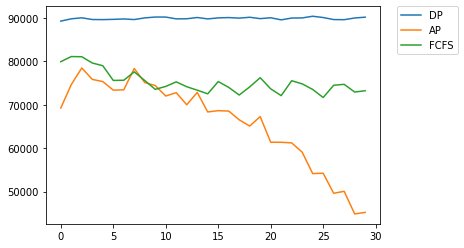

In [15]:
plt.subplot()
plt.plot(avgweeklyRev[:, 0], label="DP")
plt.plot(avgweeklyRev[:, 1], label="AP")
plt.plot(avgweeklyRev[:, 2], label="FCFS")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.show()

In [19]:
# Add week info to the output, which comes handy for visualization in RStudio.
weekdata = np.arange(1, weeks+1)
revOutput = np.column_stack((weekdata, avgweeklyRev))

In [17]:
# Export simulation results into a csv file
np.savetxt(csvfilena``me, revOutput, fmt='%i, %i, %i', delimiter=',', header="Week, DP, AP, FCFS", comments="")